# This notebook is the sample code to show how to control the style of AI Art 

# Generated Image using ControlNet.

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models by Lvmin Zhang and Maneesh Agrawala](https://arxiv.org/abs/2302.05543). It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

Let's prepare the required libraries

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

In [3]:
import cv2
from PIL import Image
import numpy as np


In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [5]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

Error caught was: No module named 'triton'


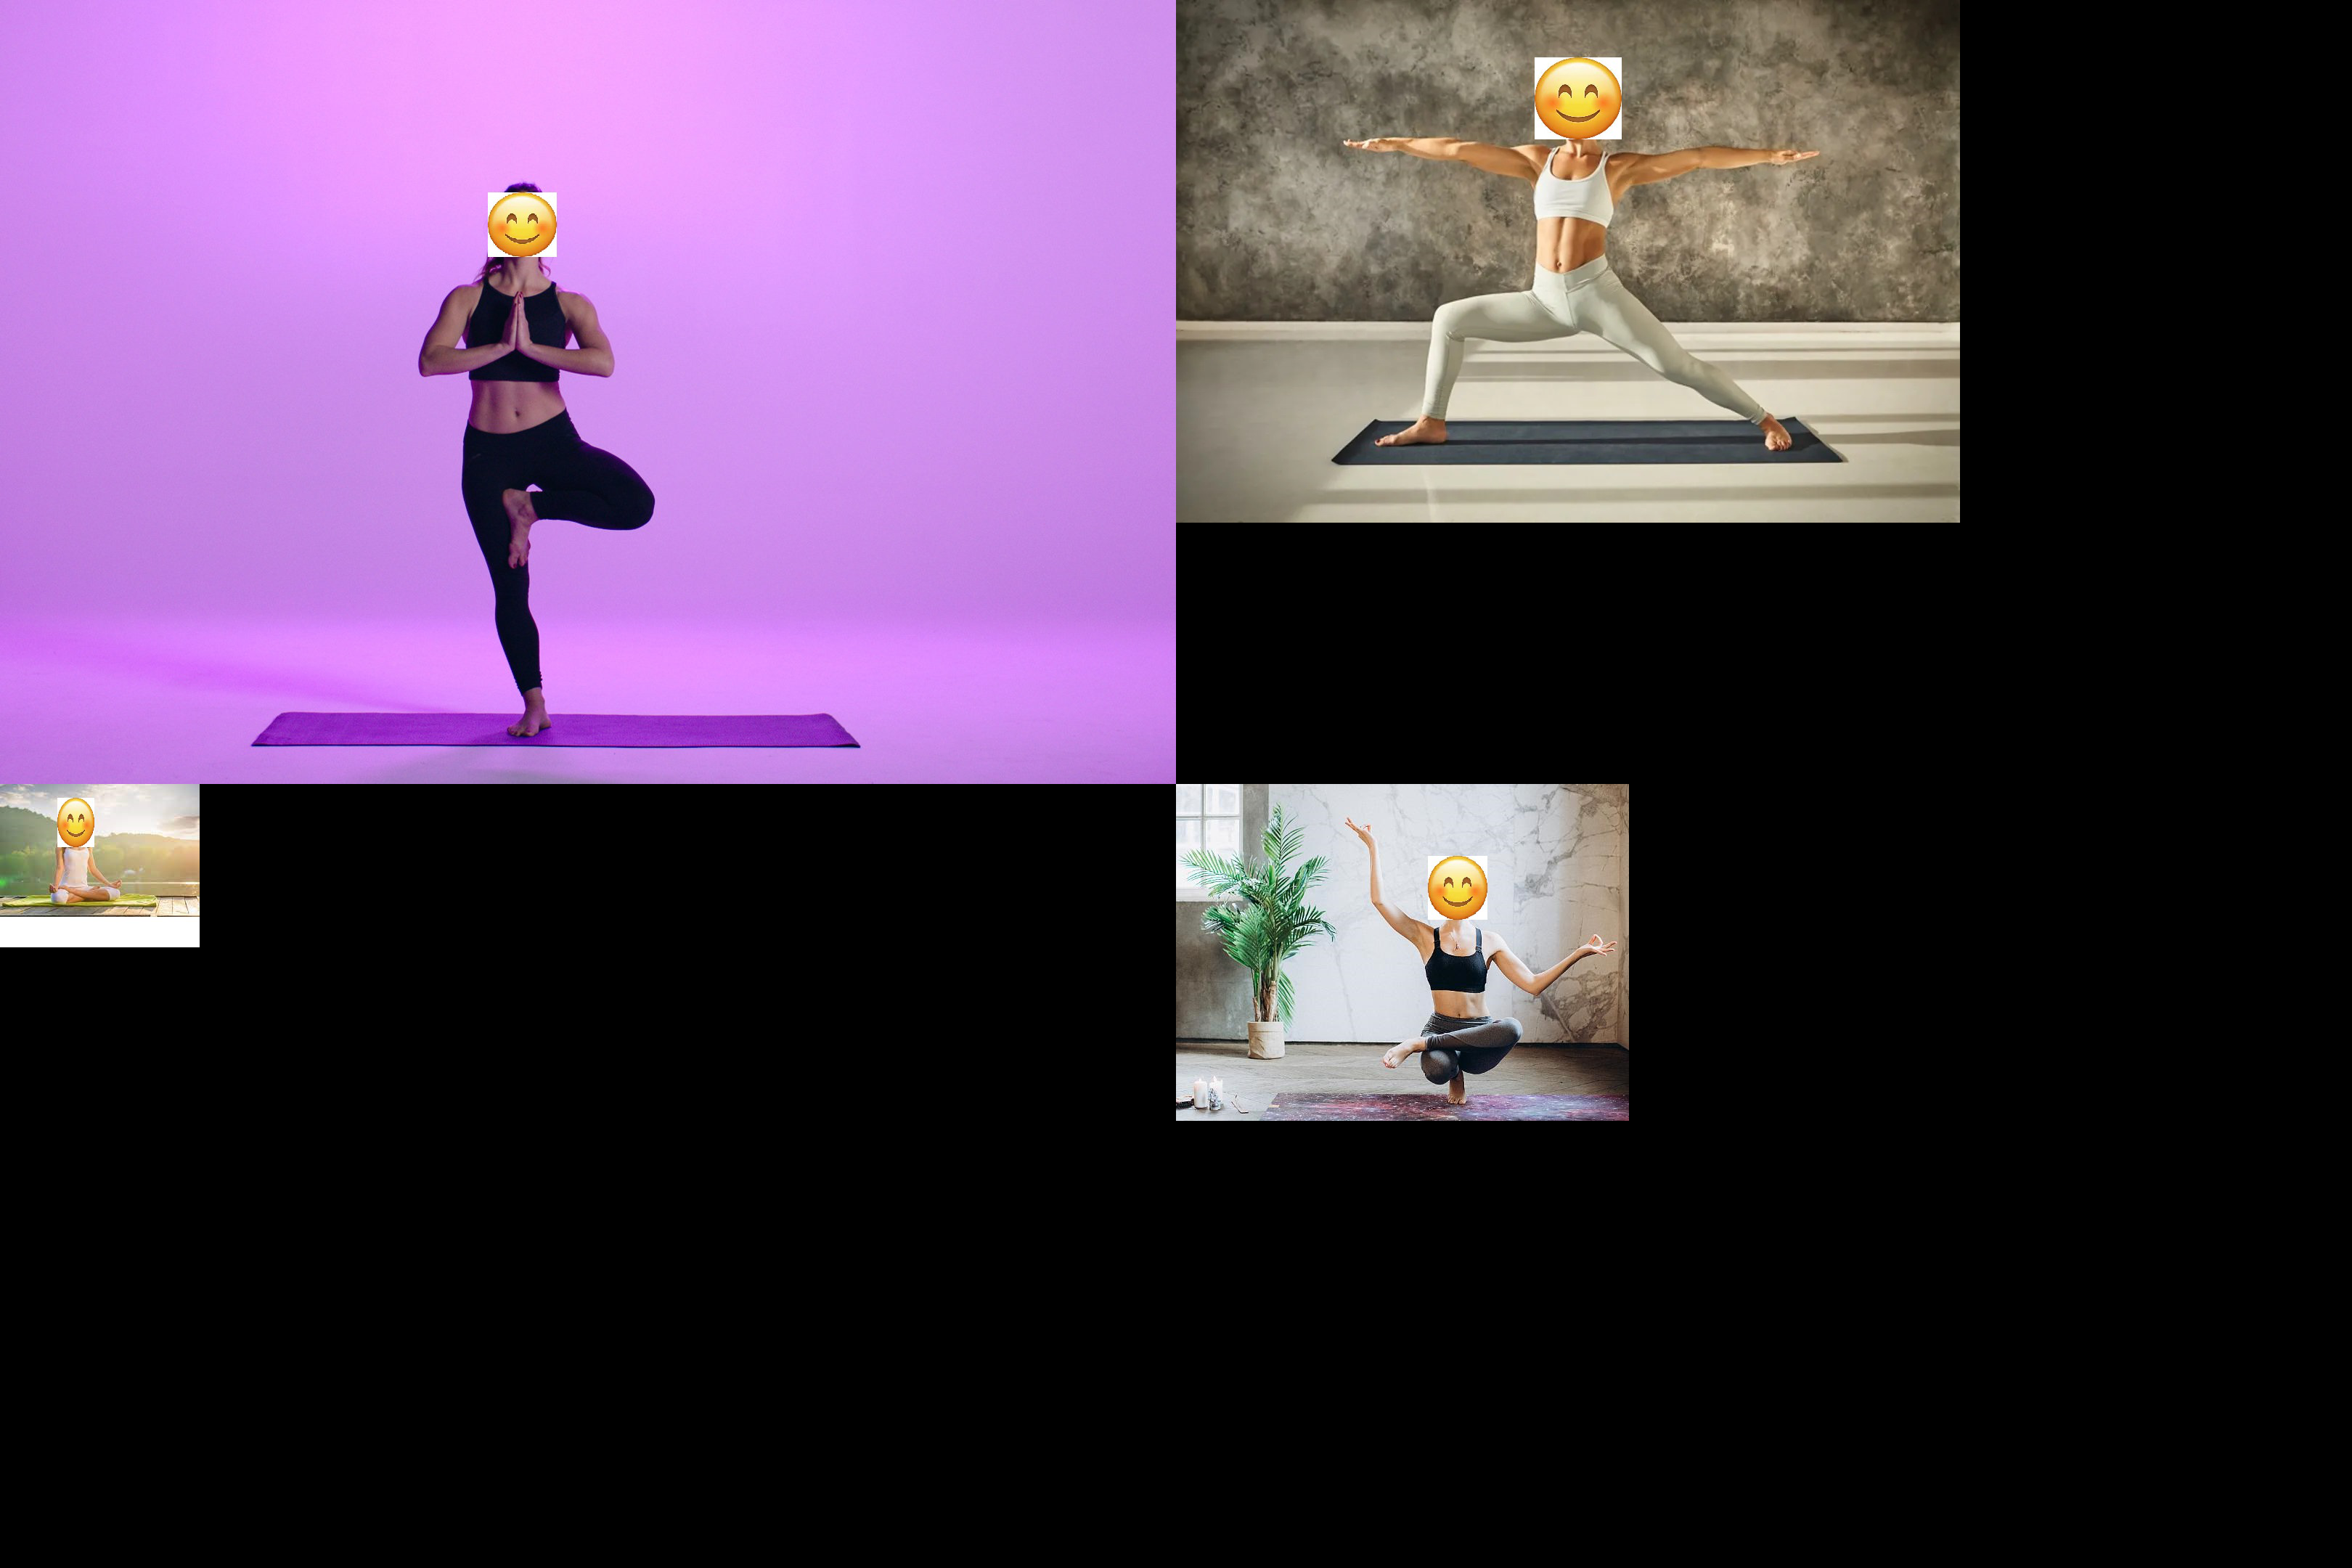

In [17]:
urls = "yoga-1.jpg", "yoga-2.jpg", "yoga-3.jpg", "yoga-4.jpg"
imgs = [
    load_image("https://beautiful-day.s3.amazonaws.com/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)

Now, let's extract yoga poses using the OpenPose pre-processors that are handily available via controlnet_aux.

cuda


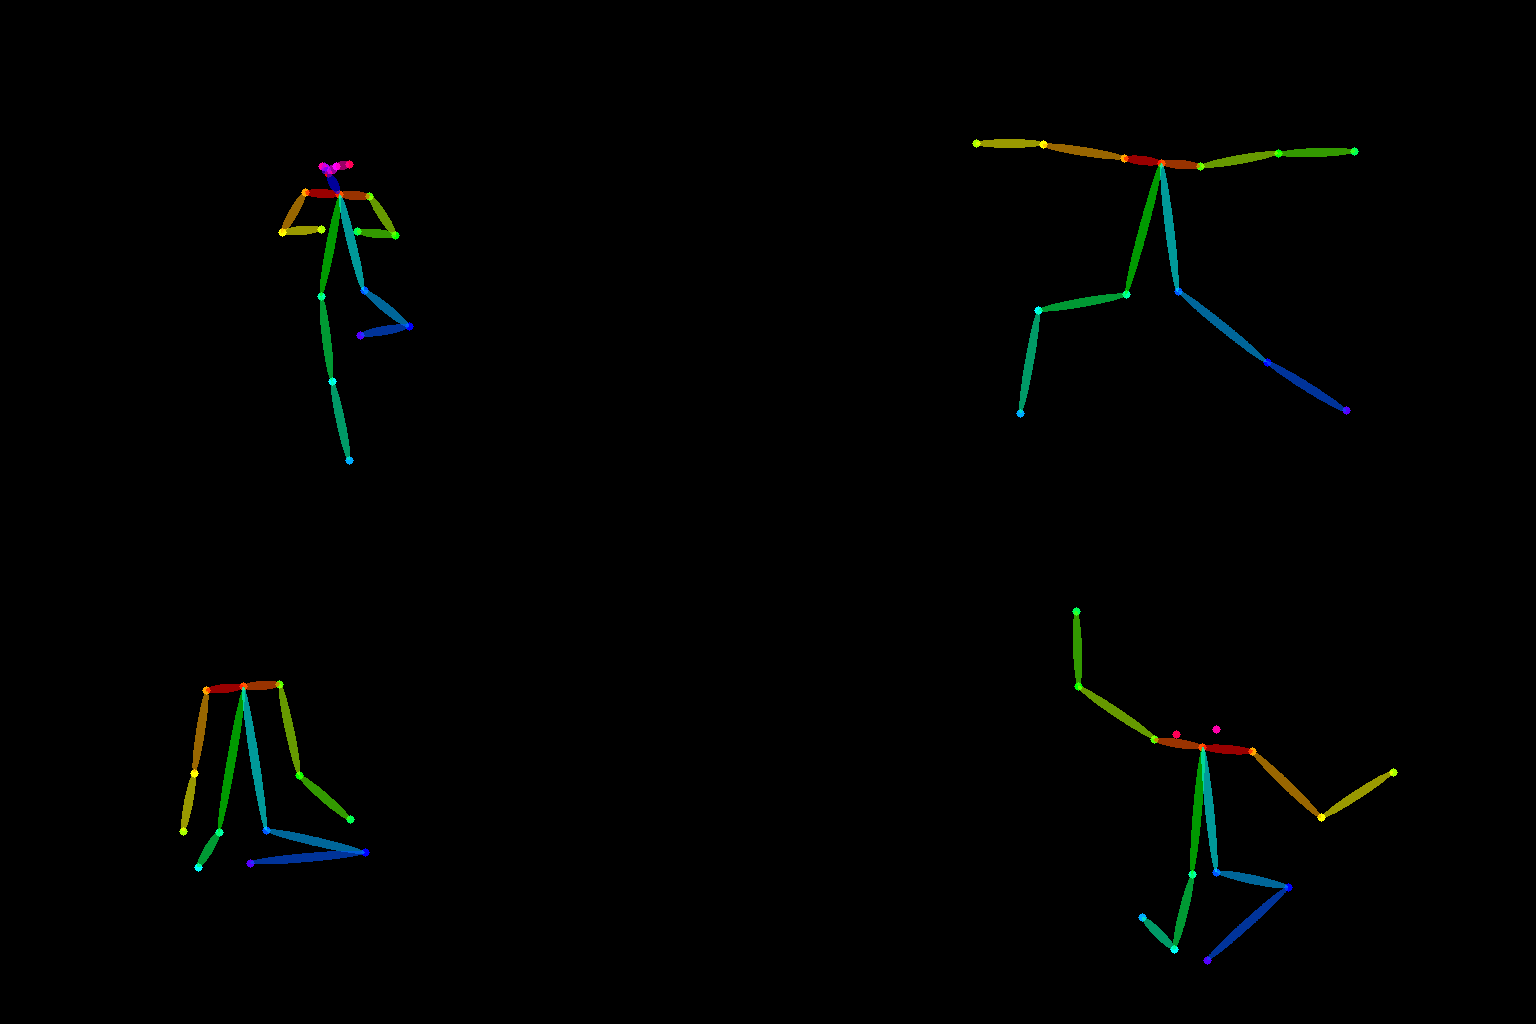

In [18]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [8]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

 

In [9]:
from diffusers import UniPCMultistepScheduler

In [10]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

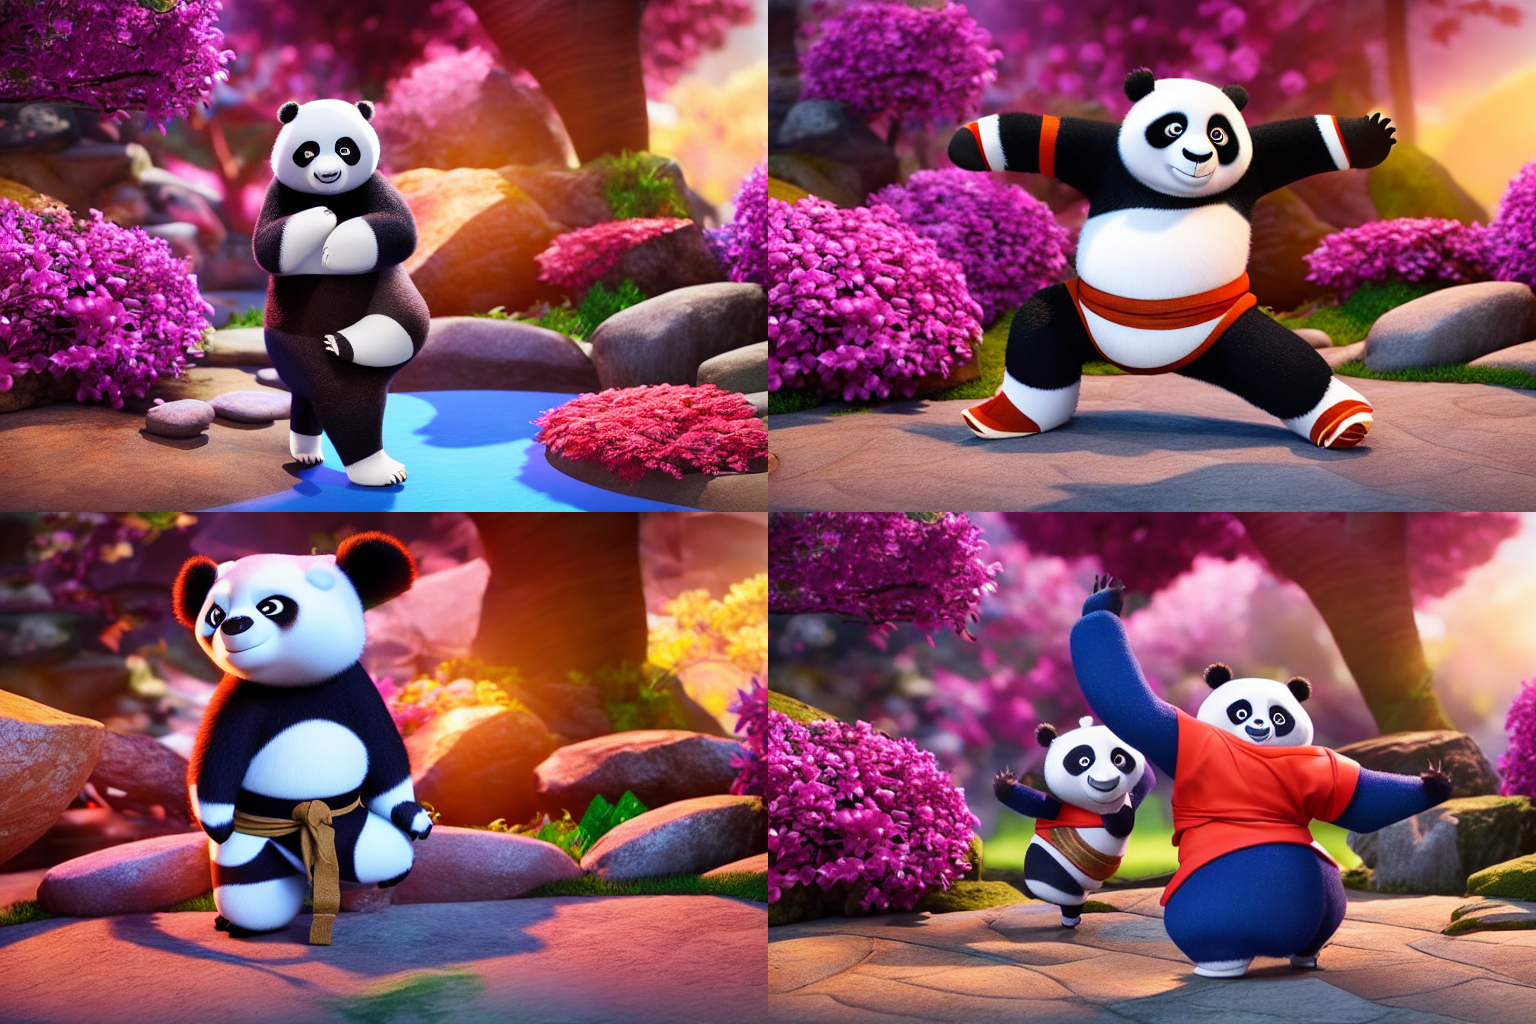

In [28]:
generator = [torch.Generator(device="cuda").manual_seed(2) for i in range(4)]
prompt = "a cute adorable kungfu panda character in japanese garden,physically based rendering,3d blender render, beautiful bright colors, 8k render,best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=50,
)
image_grid(output.images, 2, 2)